In [2]:
import os
import glob
import gzip
import pickle
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from metient.util import plotting_util as putil
from metient.util.globals import *

REPO_DIR = '/lila/data/morrisq/divyak/projects/metient/metient/'
OUTPUT_DIR = os.path.join(REPO_DIR, 'jupyter_notebooks', 'output_plots')
DATASET_NAMES = ["Breast Cancer", "HGSOC", "Melanoma", "Neuroblastoma", "NSCLC"]
CALIBRATE_DIRS = [os.path.join(REPO_DIR,"data/hoadley_breast_cancer_2016/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/mcpherson_ovarian_2016/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/sanborn_melanoma_2015/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/gundem_neuroblastoma_2023/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/tracerx_nsclc/metient_outputs/pyclone_clustered_conipher_trees_03182024/calibrate")]

desired_order = ["single-source", 'multi-source', "reseeding", "primary single-source",]

/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11030). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


CUDA GPU: False


In [3]:
import matplotlib.ticker as ticker
COLORS = sns.color_palette("flare")[1:]
print(COLORS)

def plot_seeding_distributions(df):
    for dataset,color in zip(DATASET_NAMES, COLORS):
        plt.figure(figsize=(3, 2.3))
        subset = df[df['Dataset']==dataset]
        ax = sns.histplot(data=subset, bins=len(desired_order), alpha=0.7, color=color, edgecolor=color,
                          binrange=(0, len(desired_order)), x="Top cal seeding pattern index", shrink=0.5)
        sns.despine(ax=ax, left=False, right=True, top=True, bottom=False)
        ax.set_xticks([0.5,1.5,2.5,3.5])
        ax.set_xticklabels(desired_order)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        #ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        if dataset == "NSCLC":
            plt.yticks(range(0, 120, 25))
        elif dataset == "Breast Cancer":
            plt.yticks(range(0, 2))
        elif dataset == "Neuroblastoma":
            plt.yticks(range(0, 20, 4))
        else:
            plt.yticks(range(0, 9, 2))

        plt.tight_layout(pad=1.0) 
        saved_name = "_".join(dataset.split(" "))
        plt.savefig(f"output_plots/{saved_name}_seeding_pattern_distribution.png", dpi=300)
        plt.show()
        plt.close()

[(0.888292, 0.40830288, 0.36223756), (0.81942908, 0.28911553, 0.38102921), (0.69226314, 0.23413578, 0.42480327), (0.56041794, 0.19845221, 0.44207535), (0.42355299, 0.16934709, 0.42581586)]


### What is the seeding pattern distribution for the top tree, as determined by calibrate?

In [4]:
import pyreadr

def split_pattern_clonality(full_pattern):
    clonality = full_pattern.split(" ")[0]
    pattern = " ".join(full_pattern.split(" ")[1:]).replace(" seeding", "")
    return pattern, clonality

def get_tracerx_subtype(pid):
    # Get NSCLC subtype (LUAD and LUSC)
    tracerx_patient_info = pyreadr.read_r(os.path.join('/data/morrisq/divyak/data/tracerx_nsclc_2023/20221109_TRACERx421_all_patient_df.rds'))[None]
    tracerx_patient_info['histology_multi_full_genomically.confirmed'].value_counts()

    subtype = tracerx_patient_info[tracerx_patient_info['cruk_id']==pid]['histology_multi_full_genomically.confirmed'].item()
    subtype = "LUAD" if "LUAD" in subtype else subtype
    if subtype == "Other":
        print("Not LUAD or LUSC subtype", pid)
        return "N/A"
    return subtype

data = []
for calibrate_dir,dataset in zip(CALIBRATE_DIRS, DATASET_NAMES):

    # Use glob to get the list of matching files
    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    patients = [m.split("/")[-1].split("_")[0] for m in matching_files]
    print(dataset, len(patients))
    patterns = []
    for fn in matching_files:
        with gzip.open(fn, 'rb') as f:
            pid = fn.split("/")[-1].split("_")[0]
            pkl = pickle.load(f)
            # Best calibrated tree
            V = torch.tensor(pkl[OUT_LABElING_KEY][0])
            A = torch.tensor(pkl[OUT_ADJ_KEY][0])
            sites = pkl[OUT_SITES_KEY]
            idx_to_label = pkl[OUT_IDX_LABEL_KEY][0]
            cal_pattern = putil.get_verbose_seeding_pattern(V,A)
            patterns.append(split_pattern_clonality(cal_pattern)[0])
            G = putil.get_migration_graph(V,A)
            cal_num_migs_polyclonal = (G>1).sum().item() / (G>0).sum().item() *100
            cal_num_ss = (G!=0).any(dim=1).sum().item()
            cal_seeding_clusters = putil.get_seeding_clusters(V, A, sites, idx_to_label)

            # Tree with lowest migration number, comigration number, or seeding site
            loss_dicts = pkl[OUT_LOSS_DICT_KEY]
            pars_metrics = []
            for l in loss_dicts:
                pars_metrics.append((int(l[MIG_KEY]), int(l[COMIG_KEY]), int(l[SEEDING_KEY])))
            
            mig_sorted_indices = sorted(enumerate(pars_metrics), key=lambda x: (x[1][0], x[1][1], x[1][2]))
            V = torch.tensor(pkl[OUT_LABElING_KEY][mig_sorted_indices[0][0]])
            A = torch.tensor(pkl[OUT_ADJ_KEY][mig_sorted_indices[0][0]])
            mig_num_pattern = putil.get_verbose_seeding_pattern(V,A)
            G = putil.get_migration_graph(V,A)
            mig_num_migs_polyclonal = (G>1).sum().item() / (G>0).sum().item() *100
            mig_num_ss = (G!=0).any(dim=1).sum().item()
            
            comig_sorted_indices = sorted(enumerate(pars_metrics), key=lambda x: (x[1][1], x[1][0], x[1][2]))
            V = torch.tensor(pkl[OUT_LABElING_KEY][comig_sorted_indices[0][0]])
            A = torch.tensor(pkl[OUT_ADJ_KEY][comig_sorted_indices[0][0]])
            comig_num_pattern = putil.get_verbose_seeding_pattern(V,A)
            G = putil.get_migration_graph(V,A)
            comig_num_migs_polyclonal = (G>1).sum().item() / (G>0).sum().item() *100
            comig_num_ss = (G!=0).any(dim=1).sum().item()

            ss_sorted_indices = sorted(enumerate(pars_metrics), key=lambda x: (x[1][2], x[1][0], x[1][1]))
            V = torch.tensor(pkl[OUT_LABElING_KEY][ss_sorted_indices[0][0]])
            A = torch.tensor(pkl[OUT_ADJ_KEY][ss_sorted_indices[0][0]])
            idx_to_label = pkl[OUT_IDX_LABEL_KEY][ss_sorted_indices[0][0]]
            ss_num_pattern = putil.get_verbose_seeding_pattern(V,A)
            G = putil.get_migration_graph(V,A)
            ss_num_migs_polyclonal = (G>1).sum().item() / (G>0).sum().item() *100
            ss_num_ss = (G!=0).any(dim=1).sum().item()
            ss_seeding_clusters = putil.get_seeding_clusters(V, A, sites, idx_to_label)
            
            subtype = "N/A"
            if dataset == 'NSCLC':
                subtype = get_tracerx_subtype(pid)
                

            data.append([dataset, pid, subtype, len(sites), desired_order.index(split_pattern_clonality(cal_pattern)[0]), 
                         split_pattern_clonality(cal_pattern)[0], split_pattern_clonality(cal_pattern)[1],cal_num_migs_polyclonal,cal_num_ss,cal_seeding_clusters,
                         split_pattern_clonality(mig_num_pattern)[0], split_pattern_clonality(mig_num_pattern)[1],mig_num_migs_polyclonal,mig_num_ss,
                         split_pattern_clonality(comig_num_pattern)[0], split_pattern_clonality(comig_num_pattern)[1],comig_num_migs_polyclonal,comig_num_ss,
                         split_pattern_clonality(ss_num_pattern)[0], split_pattern_clonality(ss_num_pattern)[1],ss_num_migs_polyclonal,ss_num_ss, ss_seeding_clusters])
    
    counts = Counter({p: 0 for p in desired_order})
    # Update counts with actual counts from data
    counts.update(patterns)
    print(counts)

trees_df = pd.DataFrame(data, columns=['Dataset', "Patient id", "Subtype", 'Num sites', 'Top cal seeding pattern index', 
                                       'Top cal seeding pattern', 'Top cal clonality', 'Top cal % migs poly','Top cal num ss', 'Top cal seeding clusters',
                                       'Lowest mig seeding pattern', 'Lowest mig clonality', 'Lowest mig % migs poly','Lowest mig num ss',
                                       'Lowest comig seeding pattern', 'Lowest comig clonality','Lowest comig % migs poly','Lowest comig num ss',
                                       'Lowest ss seeding pattern', 'Lowest ss clonality','Lowest ss % migs poly','Lowest ss num ss', 'Lowest ss seeding clusters'])

Breast Cancer 2
Counter({'single-source': 1, 'primary single-source': 1, 'multi-source': 0, 'reseeding': 0})
HGSOC 7
Counter({'primary single-source': 6, 'multi-source': 1, 'single-source': 0, 'reseeding': 0})
Melanoma 8
Counter({'primary single-source': 5, 'multi-source': 2, 'reseeding': 1, 'single-source': 0})
Neuroblastoma 26
Counter({'primary single-source': 19, 'multi-source': 4, 'single-source': 3, 'reseeding': 0})
NSCLC 128
Not LUAD or LUSC subtype CRUK0702
Not LUAD or LUSC subtype CRUK0514
Not LUAD or LUSC subtype CRUK0325
Not LUAD or LUSC subtype CRUK0718
Not LUAD or LUSC subtype CRUK0422
Not LUAD or LUSC subtype CRUK0596
Not LUAD or LUSC subtype CRUK0476
Not LUAD or LUSC subtype CRUK0719
Not LUAD or LUSC subtype CRUK0100
Not LUAD or LUSC subtype CRUK0557
Not LUAD or LUSC subtype CRUK0099
Not LUAD or LUSC subtype CRUK0587
Not LUAD or LUSC subtype CRUK0524
Not LUAD or LUSC subtype CRUK0484
Not LUAD or LUSC subtype CRUK0769
Not LUAD or LUSC subtype CRUK0097
Not LUAD or LUSC subt

In [5]:
trees_df

,Dataset,Patient id,Subtype,Num sites,Top cal seeding pattern index,Top cal seeding pattern,Top cal clonality,Top cal % migs poly,Top cal num ss,Top cal seeding clusters,...,Lowest mig num ss,Lowest comig seeding pattern,Lowest comig clonality,Lowest comig % migs poly,Lowest comig num ss,Lowest ss seeding pattern,Lowest ss clonality,Lowest ss % migs poly,Lowest ss num ss,Lowest ss seeding clusters
0,Breast Cancer,A1,N/A,5,3,primary single-source,polyclonal,75.000,1,"[0, 1, 2, 6, 7, 8]",...,1,primary single-source,polyclonal,75.000,1,primary single-source,polyclonal,75.000,1,"[0, 1, 2, 6, 7, 8]"
1,Breast Cancer,A7,N/A,6,0,single-source,polyclonal,40.000,3,"[0, 2, 4, 5, 7]",...,3,single-source,polyclonal,40.000,3,single-source,polyclonal,40.000,3,"[0, 2, 4, 5, 7]"
2,HGSOC,3,N/A,3,3,primary single-source,polyclonal,50.000,1,"[3, 6, 7]",...,1,primary single-source,polyclonal,50.000,1,primary single-source,polyclonal,50.000,1,"[3, 6, 7]"
3,HGSOC,7,N/A,3,1,multi-source,polyclonal,66.667,2,"[0, 2, 5, 6]",...,2,primary single-source,polyclonal,100.000,1,primary single-source,polyclonal,100.000,1,"[0, 2, 3, 6]"
4,HGSOC,9,N/A,3,3,primary single-source,polyclonal,100.000,1,"[0, 4]",...,1,primary single-source,polyclonal,100.000,1,primary single-source,polyclonal,100.000,1,"[0, 4]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,NSCLC,CRUK0368,LUAD,3,3,primary single-source,polyclonal,100.000,1,"[0, 2, 8]",...,1,primary single-source,polyclonal,100.000,1,primary single-source,polyclonal,100.000,1,"[0, 2, 8]"
167,NSCLC,CRUK0609,LUSC,2,3,primary single-source,polyclonal,100.000,1,[0],...,1,primary single-source,polyclonal,100.000,1,primary single-source,polyclonal,100.000,1,[0]
168,NSCLC,CRUK0467,LUSC,4,3,primary single-source,polyclonal,100.000,1,"[0, 1, 4, 6, 8]",...,2,primary single-source,polyclonal,100.000,1,primary single-source,polyclonal,100.000,1,"[0, 1, 4, 6, 8]"
169,NSCLC,CRUK0337,LUAD,2,3,primary single-source,polyclonal,100.000,1,[0],...,1,primary single-source,polyclonal,100.000,1,primary single-source,polyclonal,100.000,1,[0]


In [6]:
num_same_clones = 0
num_diff_clones = 0

for i,row in trees_df.iterrows():
    top_cal_clusters = set(row['Top cal seeding clusters'])
    lowest_ss_clusters = set(row['Lowest ss seeding clusters'])
    num_same_clones += len(top_cal_clusters.intersection(lowest_ss_clusters))
    num_diff_clones += len(top_cal_clusters.symmetric_difference(lowest_ss_clusters))

print("same clones", num_same_clones, "diff clones", num_diff_clones)

same clones 496 diff clones 75


### Visualize top calibrated seeding patterns together in a stacked bar plot

Index(['multi-source', 'primary single-source', 'reseeding', 'single-source'], dtype='object', name='Top cal seeding pattern') Top cal seeding pattern  multi-source  primary single-source  reseeding  \
Dataset                                                                   
   NSCLC                        8.594                 87.500      0.781   
  Neuroblastoma                15.385                 73.077      0.000   
 HGSOC                         14.286                 85.714      0.000   
Melanoma                       25.000                 62.500     12.500   

Top cal seeding pattern  single-source  
Dataset                                 
   NSCLC                         3.125  
  Neuroblastoma                 11.538  
 HGSOC                           0.000  
Melanoma                         0.000  


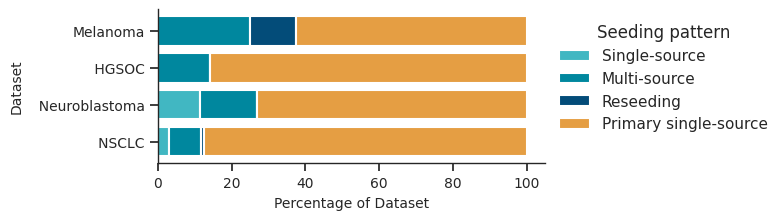

Index(['multi-source', 'primary single-source', 'reseeding', 'single-source'], dtype='object', name='Lowest mig seeding pattern') Lowest mig seeding pattern  multi-source  primary single-source  reseeding  \
Dataset                                                                      
   NSCLC                          21.094                 74.219      1.562   
  Neuroblastoma                   26.923                 61.538      0.000   
 HGSOC                            28.571                 71.429      0.000   
Melanoma                          25.000                 62.500     12.500   

Lowest mig seeding pattern  single-source  
Dataset                                    
   NSCLC                            3.125  
  Neuroblastoma                    11.538  
 HGSOC                              0.000  
Melanoma                            0.000  


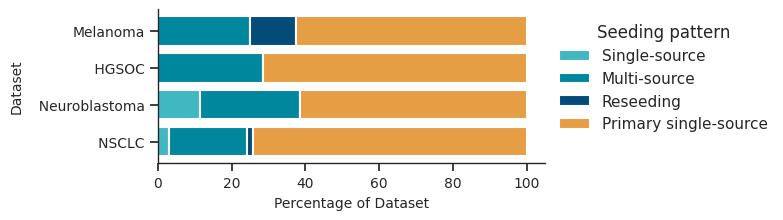

Index(['primary single-source', 'single-source', 'multi-source', 'reseeding'], dtype='object', name='Lowest comig seeding pattern') Lowest comig seeding pattern  primary single-source  single-source  \
Dataset                                                              
   NSCLC                                     96.875          3.125   
  Neuroblastoma                              88.462         11.538   
 HGSOC                                      100.000          0.000   
Melanoma                                    100.000          0.000   

Lowest comig seeding pattern  multi-source  reseeding  
Dataset                                                
   NSCLC                             0.000      0.000  
  Neuroblastoma                      0.000      0.000  
 HGSOC                               0.000      0.000  
Melanoma                             0.000      0.000  


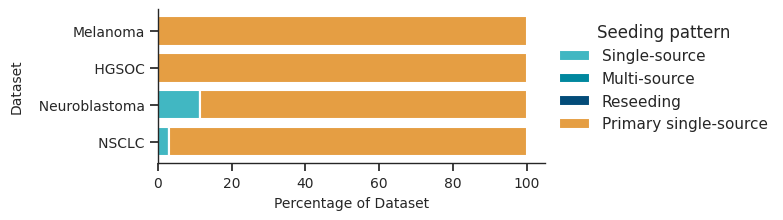

Index(['primary single-source', 'single-source', 'multi-source', 'reseeding'], dtype='object', name='Lowest ss seeding pattern') Lowest ss seeding pattern  primary single-source  single-source  multi-source  \
Dataset                                                                         
   NSCLC                                 100.000          0.000         0.000   
  Neuroblastoma                          100.000          0.000         0.000   
 HGSOC                                   100.000          0.000         0.000   
Melanoma                                 100.000          0.000         0.000   

Lowest ss seeding pattern  reseeding  
Dataset                               
   NSCLC                       0.000  
  Neuroblastoma                0.000  
 HGSOC                         0.000  
Melanoma                       0.000  


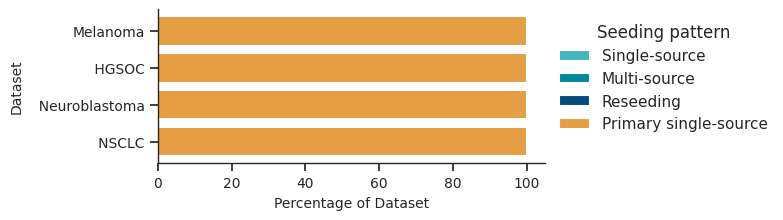

In [23]:
import numpy as np

def stacked_bar_seeding_pattern(df, key, output_name):
    df = df.copy(deep=True)
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.linewidth': 1.0})

    # hack to get desired order...
    dataset_map = {'Melanoma':'Melanoma', 'HGSOC':' HGSOC', 'Neuroblastoma':'  Neuroblastoma', 'NSCLC':'   NSCLC'}
    df['Dataset'] = df.apply(lambda row: dataset_map[row['Dataset']], axis=1)

    # Calculate the count of each category within each dataset
    category_counts = df.groupby(['Dataset', key]).size().unstack(fill_value=0)

    # Calculate proportions
    category_proportions = category_counts.div(category_counts.sum(axis=1), axis=0)*100
    for ptrn in desired_order:
        if ptrn not in category_proportions.columns: # the seeding pattern never shows up
            category_proportions[ptrn] = 0.0
    print(category_proportions.columns, category_proportions)
    fig, ax = plt.subplots(figsize=(5,2))

    # Variables to store the bottom for each bar
    bottoms = np.zeros(len(category_proportions))

    # Colors for each category
    tab_colors = ["#41b7c2", "#00879e", "#034c79", "#e59e43",]
    colors = {d:c for d,c in zip(desired_order, tab_colors)}
    sns.set(style='ticks', font="Arial")
    # Plot each category
    for column_name in desired_order:
        column_data = category_proportions[column_name]
        ax.barh(category_proportions.index, column_data,left=bottoms, label=column_name, 
               color=colors[column_name], edgecolor='white', linewidth=1.5)
        bottoms += column_data.values


    ax.set_xlabel('Percentage of Dataset')
    ax.set_ylabel('Dataset')
    legend = ax.legend(title='Seeding pattern', bbox_to_anchor=(1, 1), loc='upper left', frameon=False)  # Place legend outside the plot
    for text in legend.get_texts():
        text.set_text(text.get_text().capitalize())


    # Remove top and right axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(os.path.join(OUTPUT_DIR, f"{output_name}_distribution.png"), dpi=300,  bbox_inches='tight', pad_inches=0.5)
    plt.show()

df = trees_df[trees_df['Dataset']!='Breast Cancer']
# df = df[df['Num sites']>2]
stacked_bar_seeding_pattern(df, 'Top cal seeding pattern', 'stacked_bar_top_cal_seeding_pattern')
stacked_bar_seeding_pattern(df, 'Lowest mig seeding pattern', 'stacked_bar_lowest_mig_seeding_pattern')
stacked_bar_seeding_pattern(df, 'Lowest comig seeding pattern', 'stacked_bar_lowest_comig_seeding_pattern')
stacked_bar_seeding_pattern(df, 'Lowest ss seeding pattern', 'stacked_bar_lowest_ss_seeding_pattern')


Top cal % migs poly
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=7.004e-01 stat=-3.934e-01
HGSOC v.s. Neuroblastoma: Welch's t-test independent samples, P_val=5.095e-02 stat=2.120e+00
Neuroblastoma v.s. NSCLC: Welch's t-test independent samples, P_val=1.012e-03 stat=-3.632e+00
Melanoma v.s. Neuroblastoma: Welch's t-test independent samples, P_val=1.355e-01 stat=1.574e+00
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=7.182e-01 stat=-3.760e-01
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=4.146e-01 stat=-8.611e-01


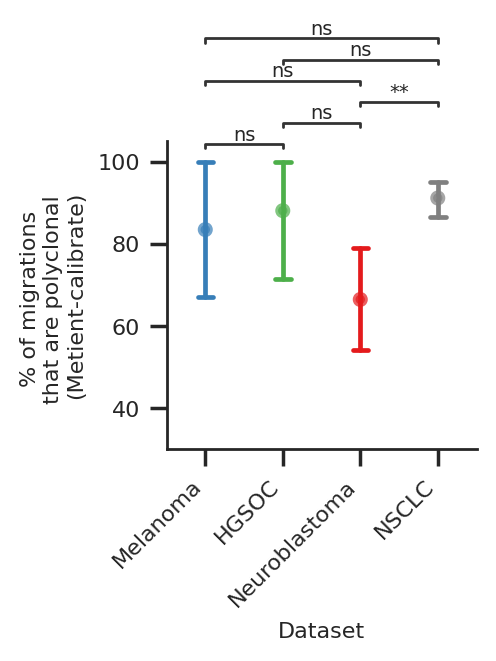

Top cal num ss
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=3.361e-01 stat=1.000e+00
HGSOC v.s. Neuroblastoma: Welch's t-test independent samples, P_val=1.858e-01 stat=-1.359e+00
Neuroblastoma v.s. NSCLC: Welch's t-test independent samples, P_val=9.300e-02 stat=1.743e+00
Melanoma v.s. Neuroblastoma: Welch's t-test independent samples, P_val=7.432e-01 stat=-3.318e-01
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=9.473e-01 stat=6.860e-02
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=2.313e-01 stat=1.304e+00


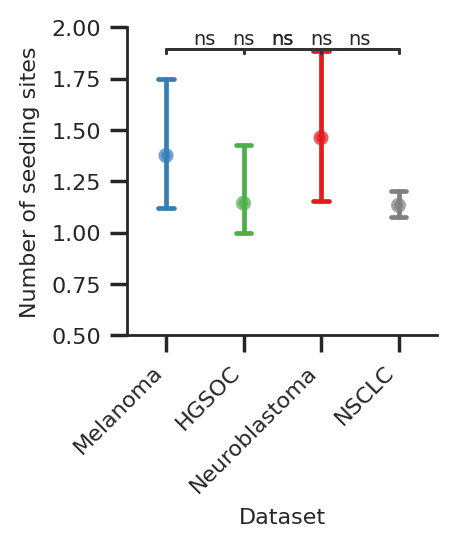

In [28]:
import itertools
from statannot import add_stat_annotation

def point_plot_comparing_datasets(df, key, ylim, ylabel, output_name, with_stat,offset=0.02):
    df = df.copy(deep=True)
    print(key)
    
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})

    fig = plt.figure(figsize=(2,2), dpi=200)
    order = ['Melanoma','HGSOC','Neuroblastoma', 'NSCLC' ]
    colors =  [sns.color_palette("Set1")[1],sns.color_palette("Set1")[2], sns.color_palette("Set1")[0],(0.5, 0.5, 0.5)]
    snsfig = sns.pointplot(data=df, x='Dataset', y=key, errwidth=1.7, order=order,
                           dodge=True, markers='.', errorbar='se', palette=colors, capsize=0.2)
  
    if with_stat:
        
        add_stat_annotation(snsfig, data=df, x='Dataset', y=key,
                            box_pairs=itertools.combinations(order, 2),order=order, line_offset=offset,
                            test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.5, 
                            text_offset=0.01, verbose=2,  fontsize=7, comparisons_correction=None,linewidth=1.0,
                            )
        
    snsfig.set_xticklabels(snsfig.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.xlabel("Dataset", fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.ylim(ylim[0],ylim[1])
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.7)
    plt.savefig(os.path.join(OUTPUT_DIR, f"{output_name}_distribution.png"), dpi=500,  bbox_inches='tight', pad_inches=0.1)

    plt.show()
    plt.close()
    
no_bc_df = trees_df[trees_df['Dataset']!='Breast Cancer']
point_plot_comparing_datasets(no_bc_df, 'Top cal % migs poly',(30,105), "% of migrations \nthat are polyclonal \n(Metient-calibrate)", 'num_migs_poly_calibrate_bw_datasets', True)
# point_plot_clonality(df, 'Lowest mig % migs poly', 'blah')
# point_plot_clonality(df, 'Lowest comig % migs poly', 'blah')
#point_plot_comparing_datasets(df, 'Lowest ss % migs poly', (0.3,1.1),"Fraction of migrations \nthat are polyclonal",'blah', True)
point_plot_comparing_datasets(no_bc_df, 'Top cal num ss', (0.5,2.0),"Number of seeding sites", 'num_ss_calibrate_bw_datasets', True, offset=0.9)



                      Type   Value
0    Lowest ss % migs poly  50.000
1    Lowest ss % migs poly 100.000
2    Lowest ss % migs poly 100.000
3    Lowest ss % migs poly 100.000
4    Lowest ss % migs poly 100.000
..                     ...     ...
333    Top cal % migs poly 100.000
334    Top cal % migs poly 100.000
335    Top cal % migs poly 100.000
336    Top cal % migs poly 100.000
337    Top cal % migs poly 100.000

[338 rows x 2 columns]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lowest ss % migs poly v.s. Top cal % migs poly: t-test paired samples, P_val=6.096e-06 stat=4.672e+00


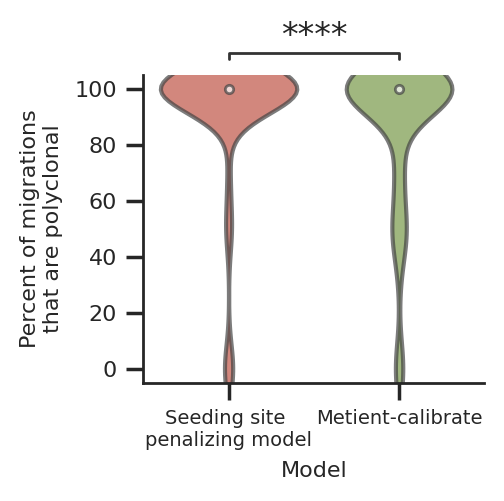

                 Type  Value
0    Lowest ss num ss      1
1    Lowest ss num ss      1
2    Lowest ss num ss      1
3    Lowest ss num ss      1
4    Lowest ss num ss      1
..                ...    ...
333    Top cal num ss      1
334    Top cal num ss      1
335    Top cal num ss      1
336    Top cal num ss      1
337    Top cal num ss      1

[338 rows x 2 columns]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lowest ss num ss v.s. Top cal num ss: t-test paired samples, P_val=1.968e-06 stat=-4.929e+00


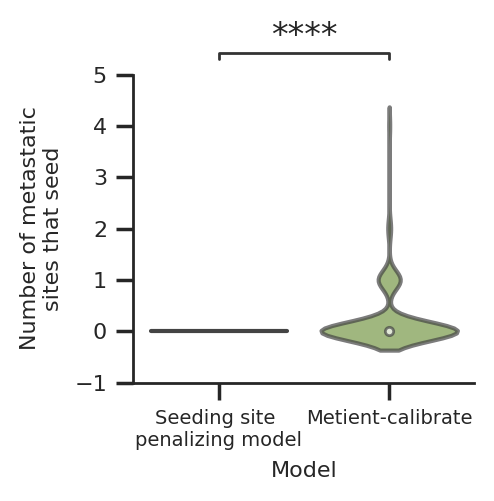

In [27]:
def violin_plot_comparison(df, keys,ylim, ylabel,output_name,subtract_one=False,):
    df = df.copy(deep=True)
    df_long = df.melt(value_vars=keys, var_name='Type', value_name='Value')
    print(df_long)
    if subtract_one: # for metastatic seeding sites vs all seeding sites
        df_long['Value'] = df_long['Value'] - 1
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(2.2,2), dpi=200)
    
    types = df_long['Type'].unique()
    colors = ["#d44432", "#7aa63c"]
 
    snsfig = sns.violinplot(data=df_long, x='Type', y='Value', 
                           dodge=True, palette=colors)
    snsfig.set_xticklabels(['Seeding site \npenalizing model', 'Metient-calibrate'], rotation=0, fontsize=7)

    plt.xlabel("Model", fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.ylim(ylim[0],ylim[1])
    add_stat_annotation(snsfig, data=df_long, x='Type', y="Value",
                        box_pairs=[keys], line_offset=0.05,
                        test='t-test_paired', text_format='star', loc='outside', line_offset_to_box=0.00005, 
                        text_offset=0.00001, verbose=2,  fontsize=12, comparisons_correction=None,linewidth=1.0,
                        )    
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.7)
    plt.savefig(os.path.join(OUTPUT_DIR,f"{output_name}_violinplot_ssmodel_vs_calmodel.png"), dpi=500,  bbox_inches='tight', pad_inches=0.5)
    plt.show()
    plt.close()

violin_plot_comparison(no_bc_df, ['Lowest ss % migs poly', 'Top cal % migs poly'],(-5,105),"Percent of migrations\nthat are polyclonal","percent_polyclonal")
violin_plot_comparison(no_bc_df, ['Lowest ss num ss', 'Top cal num ss'],(-1,5),"Number of metastatic\nsites that seed", "number_met_ss",subtract_one=True, )



                         Dataset                   Type   Value
0    HGSOC Lowest ss % migs poly  Lowest ss % migs poly  50.000
1    HGSOC Lowest ss % migs poly  Lowest ss % migs poly 100.000
2    HGSOC Lowest ss % migs poly  Lowest ss % migs poly 100.000
3    HGSOC Lowest ss % migs poly  Lowest ss % migs poly 100.000
4    HGSOC Lowest ss % migs poly  Lowest ss % migs poly 100.000
..                           ...                    ...     ...
333    NSCLC Top cal % migs poly    Top cal % migs poly 100.000
334    NSCLC Top cal % migs poly    Top cal % migs poly 100.000
335    NSCLC Top cal % migs poly    Top cal % migs poly 100.000
336    NSCLC Top cal % migs poly    Top cal % migs poly 100.000
337    NSCLC Top cal % migs poly    Top cal % migs poly 100.000

[338 rows x 3 columns]
[['Melanoma Lowest ss % migs poly', 'Melanoma Top cal % migs poly'], ['HGSOC Lowest ss % migs poly', 'HGSOC Top cal % migs poly'], ['Neuroblastoma Lowest ss % migs poly', 'Neuroblastoma Top cal % migs poly'],

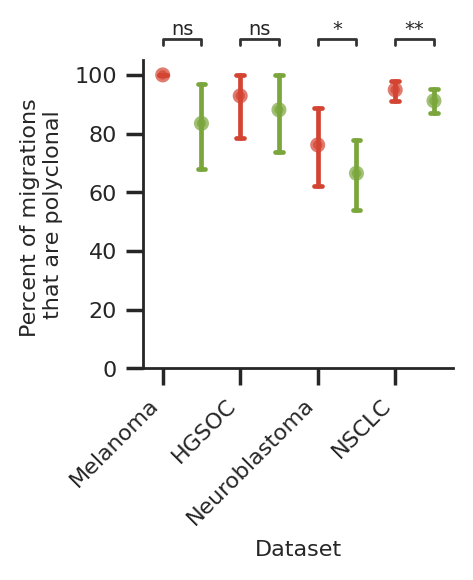

                    Dataset              Type  Value
0    HGSOC Lowest ss num ss  Lowest ss num ss      1
1    HGSOC Lowest ss num ss  Lowest ss num ss      1
2    HGSOC Lowest ss num ss  Lowest ss num ss      1
3    HGSOC Lowest ss num ss  Lowest ss num ss      1
4    HGSOC Lowest ss num ss  Lowest ss num ss      1
..                      ...               ...    ...
333    NSCLC Top cal num ss    Top cal num ss      1
334    NSCLC Top cal num ss    Top cal num ss      1
335    NSCLC Top cal num ss    Top cal num ss      1
336    NSCLC Top cal num ss    Top cal num ss      1
337    NSCLC Top cal num ss    Top cal num ss      1

[338 rows x 3 columns]
[['Melanoma Lowest ss num ss', 'Melanoma Top cal num ss'], ['HGSOC Lowest ss num ss', 'HGSOC Top cal num ss'], ['Neuroblastoma Lowest ss num ss', 'Neuroblastoma Top cal num ss'], ['NSCLC Lowest ss num ss', 'NSCLC Top cal num ss']]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e

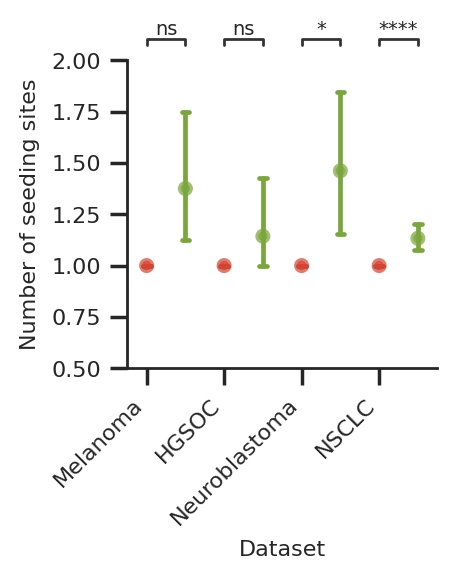

In [10]:

def point_plot_comparison(df, keys, ylim, ylabel, output_name, with_stats=True):
    df = df.copy(deep=True)
    df_long = df.melt(id_vars='Dataset', value_vars=keys, var_name='Type', value_name='Value')
    df_long['Dataset'] = df_long.apply(lambda row: f"{row['Dataset']} {row['Type']}", axis=1)
    print(df_long)
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})

    fig = plt.figure(figsize=(2,2), dpi=200)
    
    types = df_long['Type'].unique()
    order = ['Melanoma','HGSOC','Neuroblastoma', 'NSCLC']
    full_order = []
    colors = ["#d44432", "#7aa63c"]*len(order)
    groups = []
    for o in order:
        group = []
        for t in types:
            full_order.append(f"{o} {t}")
            group.append(f"{o} {t}")
        groups.append(group)
    print(groups)
    snsfig = sns.pointplot(data=df_long, x='Dataset', y='Value', s=5, errwidth=1.7, order=full_order,
                           dodge=True, markers='.', errorbar='se', palette=colors, capsize=0.2)
    plt.xlabel("Dataset", fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.ylim(ylim[0],ylim[1])
    if with_stats:
        add_stat_annotation(snsfig, data=df_long, x='Dataset', y="Value",
                            box_pairs=groups,order=full_order, line_offset=0.05,
                            test='t-test_paired', text_format='star', loc='outside', line_offset_to_box=0.00005, 
                            text_offset=0.00001, verbose=2,  fontsize=7, comparisons_correction=None,linewidth=1.0,
                            )
    plt.xticks([x for x in range(0,len(order)*2,2)], order, rotation=45,horizontalalignment='right')
    
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.7)
    plt.savefig(os.path.join(OUTPUT_DIR,f"{output_name}_distribution.png"), dpi=500,  bbox_inches='tight', pad_inches=0.5)
    plt.show()
    plt.close()

point_plot_comparison(no_bc_df, ['Lowest ss % migs poly', 'Top cal % migs poly'], (0,105), "Percent of migrations \nthat are polyclonal", 'num_migs_poly_calibrate_vs_lowest_ss')
point_plot_comparison(no_bc_df, ['Lowest ss num ss', 'Top cal num ss'], (0.5,2.0), "Number of seeding sites",'num_ss_calibrate_vs_lowest_ss', with_stats=True)


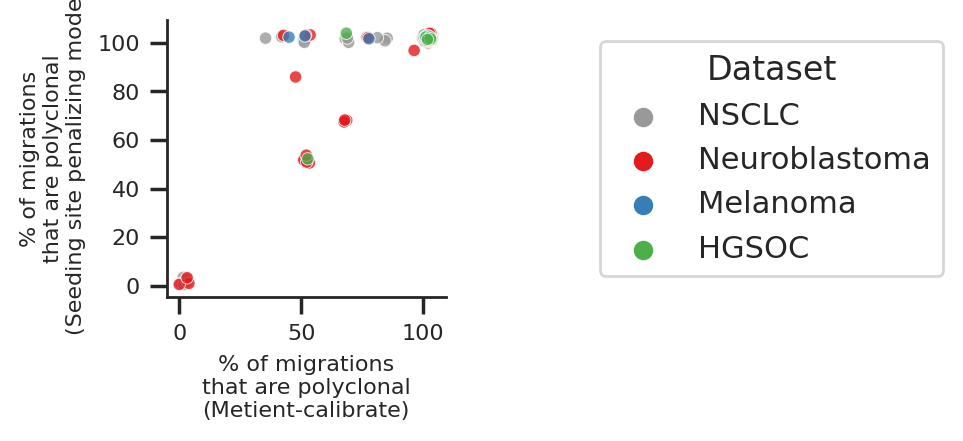

<Figure size 360x360 with 0 Axes>

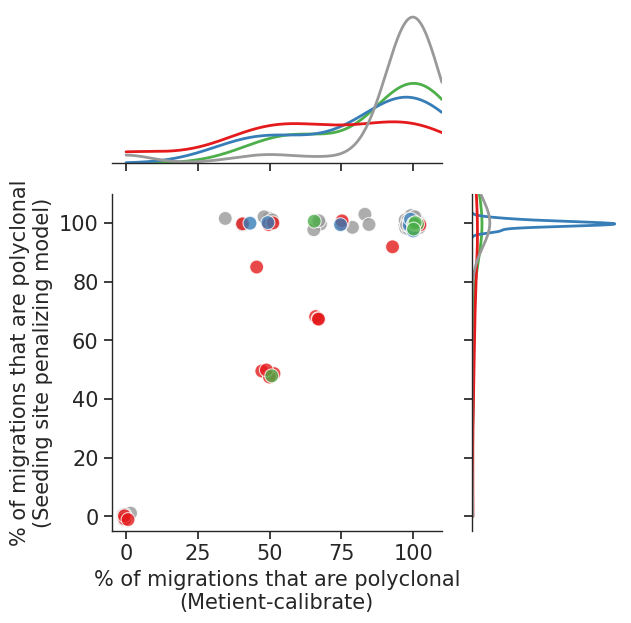

In [26]:

def joint_plot(df, keys, output_name):
    df = df.copy(deep=True)   
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(1.8,1.8), dpi=200)
    order = ['NSCLC','Neuroblastoma','Melanoma','HGSOC',]
    df['Dataset'] = pd.Categorical(df['Dataset'], categories=order, ordered=True)
    # Sort the DataFrame based on the custom order of the 'Department' column
    df = df.sort_values(by='Dataset')
    colors = [(0.6, 0.6, 0.6)] + sns.color_palette("Set1")
    g = sns.JointGrid(data=df, x=jitter(df[keys[0]], 0.05), y=jitter(df[keys[1]], 0), 
                      hue='Dataset', palette=colors[:4], ratio=2, xlim=(-5,110), ylim=(-5,110))
    g.plot_joint(sns.scatterplot, s=100, alpha=0.8, hue='Dataset',palette=colors[:4])
    g.plot_marginals(sns.kdeplot, common_norm=False, hue='Dataset',palette=colors[:4], fill=False, clip=(0,110), linewidth=2)
    g.set_axis_labels("% of migrations that are polyclonal\n(Metient-calibrate)", "% of migrations that are polyclonal\n(Seeding site penalizing model)",fontsize=15)
    g.ax_joint.tick_params(axis='both', labelsize=15)
    g.ax_marg_x.spines['left'].set_linewidth(2)

    g.ax_joint.legend_.remove()

    plt.savefig(os.path.join(OUTPUT_DIR,f"joint_plot_ssmodel_vs_calmodel_percent_polyclonal.png"), dpi=500,  bbox_inches='tight', pad_inches=0.5)
    plt.show()
    plt.close()

def jitter(values,j):
    return values + np.random.normal(j,1,values.shape)

def scatter_plot_comparison(df, keys, output_name): 
    df = df.copy(deep=True)   
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(1.8,1.8), dpi=200)
    order = ['NSCLC','Neuroblastoma','Melanoma','HGSOC',]
    df['Dataset'] = pd.Categorical(df['Dataset'], categories=order, ordered=True)
    # Sort the DataFrame based on the custom order of the 'Department' column
    df = df.sort_values(by='Dataset')
    colors = [(0.6, 0.6, 0.6)] + sns.color_palette("Set1")
    snsfig = sns.scatterplot(x=jitter(df[keys[0]], 2), y=jitter(df[keys[1]], 2), 
                             hue='Dataset', data=df, s=20,palette=colors[:4])
    
    
    snsfig.legend(loc='center left', bbox_to_anchor=(1.5, 0.5), title='Dataset')
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.8)
    plt.xlabel("% of migrations\nthat are polyclonal\n(Metient-calibrate)", fontsize=8)
    plt.ylabel("% of migrations\nthat are polyclonal\n(Seeding site penalizing model)", fontsize=8)
    plt.savefig(os.path.join(OUTPUT_DIR,f"scatter_plot_ssmodel_vs_calmodel_percent_polyclonal.png"), dpi=500,  bbox_inches='tight', pad_inches=0.5)
    plt.show()
    plt.close()

scatter_plot_comparison(no_bc_df, ['Top cal % migs poly', 'Lowest ss % migs poly'], 'blah')
#scatter_hist_model_comparison(no_bc_df, ['Top cal % migs poly', 'Lowest ss % migs poly'], 'blah')
joint_plot(no_bc_df, ['Top cal % migs poly', 'Lowest ss % migs poly'], 'blah')


### Are there any significant differences between LUSC and LUAD subtypes?

['LUSC' 'LUAD']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LUSC v.s. LUAD: Welch's t-test independent samples, P_val=1.348e-01 stat=-1.516e+00


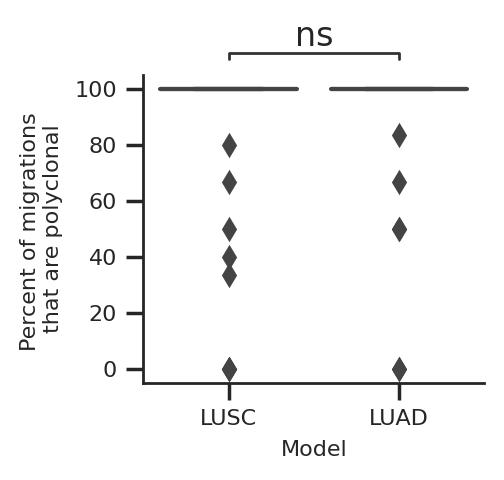

['LUSC' 'LUAD']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LUSC v.s. LUAD: Welch's t-test independent samples, P_val=1.238e-01 stat=1.563e+00


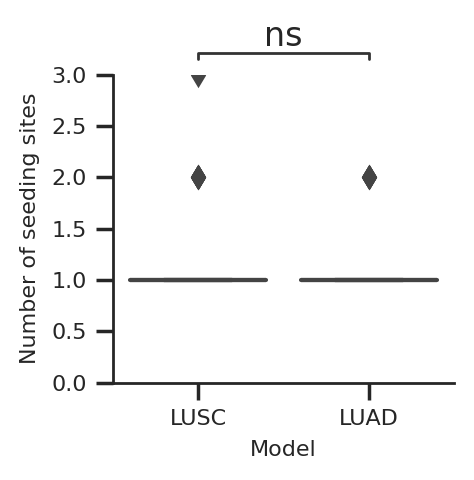

In [12]:

def box_plot_comparison_nsclc_subtypes(df, y,ylim,ylabel,output_name):
    
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(2.2,2), dpi=200)
    
    colors = ["#d44432", "#7aa63c"]
 
    snsfig = sns.boxplot(data=df, x='Subtype', y=y, 
                           dodge=True, palette=colors)
#     snsfig.set_xticklabels(['Seeding site \npenalizing model', 'Metient-calibrate'], rotation=0, fontsize=7)

    plt.xlabel("Model", fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.ylim(ylim[0],ylim[1])
    subtypes = nsclc_subset['Subtype'].unique()
    print(subtypes)
    add_stat_annotation(snsfig, data=df, x='Subtype', y=y,
                        box_pairs=[subtypes], line_offset=0.05,
                        test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.00005, 
                        text_offset=0.00001, verbose=2,  fontsize=12, comparisons_correction=None,linewidth=1.0,
                        )    
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    plt.setp(snsfig.collections, alpha=0.7)
    plt.savefig(os.path.join(OUTPUT_DIR,f"{output_name}_boxplot_ssmodel_vs_calmodel.png"), dpi=500,  bbox_inches='tight', pad_inches=0.5)
    plt.show()
    plt.close()


nsclc_subset = trees_df[(trees_df['Dataset']=='NSCLC') & (trees_df['Subtype']!='N/A')]
box_plot_comparison_nsclc_subtypes(nsclc_subset, "Top cal % migs poly", (-5,105), "Percent of migrations \nthat are polyclonal", 'num_migs_poly_calibrate_vs_lowest_ss')

box_plot_comparison_nsclc_subtypes(nsclc_subset, "Top cal num ss", (0,3), "Number of seeding sites", 'num_migs_poly_calibrate_vs_lowest_ss')



### What would the seeding pattern distributions be if we adopted the tie breaking model? (minimize migration # first, then comigration then seeding site)

In [13]:
data = []
for calibrate_dir,dataset in zip(CALIBRATE_DIRS, DATASET_NAMES):

    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    patients = [m.split("/")[-1].split("_")[0] for m in matching_files]
    print("\n", dataset, len(patients))
    patterns = []
    for patient, fn in zip(patients, matching_files):
        pars_metrics = []
        with gzip.open(fn, 'rb') as f:
            pkl = pickle.load(f)
            loss_dicts = pkl[OUT_LOSS_DICT_KEY]
            for l in loss_dicts:
                pars_metrics.append((int(l[MIG_KEY]), int(l[COMIG_KEY]), int(l[SEEDING_KEY])))
            
            sorted_indices = sorted(enumerate(pars_metrics), key=lambda x: (x[1][0], x[1][1], x[1][2]))
            best_index = sorted_indices[0][0]
#             print()
#             print(patient, pars_metrics)
#             print(sorted_indices)
            if best_index != 0: 
                print("Different result:", dataset, patient)
            V = torch.tensor(pkl[OUT_LABElING_KEY][best_index])
            A = torch.tensor(pkl[OUT_ADJ_KEY][best_index])
                
            pattern = " ".join(putil.get_verbose_seeding_pattern(V,A).split(" ")[1:]).replace(" seeding", "")
            patterns.append(pattern)
            data.append([dataset, desired_order.index(pattern)])
    print(set(patterns))
    
    counts = Counter({p: 0 for p in desired_order})
    # Update counts with actual counts from data
    counts.update(patterns)
    print(counts)

tie_scheme_df = pd.DataFrame(data, columns=['dataset', 'seeding pattern'])
plot_seeding_distributions(tie_scheme_df)


 Breast Cancer 2
{'single-source', 'primary single-source'}
Counter({'single-source': 1, 'primary single-source': 1, 'multi-source': 0, 'reseeding': 0})

 HGSOC 7
Different result: HGSOC 1
{'multi-source', 'primary single-source'}
Counter({'primary single-source': 5, 'multi-source': 2, 'single-source': 0, 'reseeding': 0})

 Melanoma 8
{'multi-source', 'reseeding', 'primary single-source'}
Counter({'primary single-source': 5, 'multi-source': 2, 'reseeding': 1, 'single-source': 0})

 Neuroblastoma 26
Different result: Neuroblastoma H132383
Different result: Neuroblastoma H118706
Different result: Neuroblastoma H132386
{'multi-source', 'single-source', 'primary single-source'}
Counter({'primary single-source': 16, 'multi-source': 7, 'single-source': 3, 'reseeding': 0})

 NSCLC 128
Different result: NSCLC CRUK0495
Different result: NSCLC CRUK0722
Different result: NSCLC CRUK0762
Different result: NSCLC CRUK0620
Different result: NSCLC CRUK0343
Different result: NSCLC CRUK0029
Different re

KeyError: 'Dataset'

<Figure size 300x230 with 0 Axes>

In [ ]:

met_site_to_polyclonal_data = []
tracerx_dir = CALIBRATE_DIRS[-1]
# Use glob to get the list of matching files
matching_files = glob.glob(f'{tracerx_dir}/*pkl.gz')
patients = [m.split("/")[-1].split("_")[0] for m in matching_files]
print(dataset, len(patients))
for fn in matching_files:
    with gzip.open(fn, 'rb') as f:
        pkl = pickle.load(f)
        # Best calibrated tree
        V = torch.tensor(pkl[OUT_LABElING_KEY][0])
        A = torch.tensor(pkl[OUT_ADJ_KEY][0])
        sites = pkl[OUT_SITES_KEY]
        G = putil.get_migration_graph(V,A)
        prim_sites = [i for i,s in enumerate(sites) if "primary" in s]
        #print(sites, prim_sites)
        #print(G)
        for i in prim_sites:
            for j, met_site in enumerate(sites):
                if i==j: continue
                is_polyclonal = int(G[i,j]>1)
                category = "LN" if met_site.startswith("LN") else "Other"
                met_site_to_polyclonal_data.append([category, is_polyclonal, int(G[i,j])])

met_site_to_polyclonal_df = pd.DataFrame(data=met_site_to_polyclonal_data, columns=["Metastatic site", "Is polyclonal", "Number of metastasizing clones"])

sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
fig = plt.figure(figsize=(2.2,2), dpi=200)

colors = ["#d44432", "#7aa63c"]

snsfig = sns.boxplot(data=met_site_to_polyclonal_df, x='Metastatic site', y="Number of metastasizing clones", 
                       dodge=True, palette=colors)
plt.xlabel("Model", fontsize=8)
plt.ylabel("Number of metastasizing clones", fontsize=8)
plt.ylim(-1,6)
subtypes = met_site_to_polyclonal_df["Metastatic site"].unique()
add_stat_annotation(snsfig, data=met_site_to_polyclonal_df, x='Metastatic site', y="Number of metastasizing clones",
                    box_pairs=[subtypes], line_offset=0.05,
                    test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.00005, 
                    text_offset=0.00001, verbose=2,  fontsize=12, comparisons_correction=None,linewidth=1.0,
                    )    
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
plt.setp(snsfig.collections, alpha=0.7)
plt.show()
plt.close()


In [ ]:
met_site_to_polyclonal_df[met_site_to_polyclonal_df['Metastatic site']=='LN']['Is polyclonal'].value_counts()

In [ ]:
met_site_to_polyclonal_df[met_site_to_polyclonal_df['Metastatic site']=='Other']['Is polyclonal'].value_counts()